In [1]:
import sys
import os
# Navigate relative to the current working directory
sys.path.append(os.path.abspath('../src'))

import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman']  # or Times New Roman, etc.

import seaborn as sns
from itertools import accumulate

import numpy as np
import pandas as pd
from sixdman.core.network import Network
from sixdman.core.band import Band, OpticalParameters
from sixdman.core.planning import PlanningTool
from sixdman.core.visualize import analyse_result
from sixdman.utils.paths import get_project_root

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Use it to get paths
project_root = get_project_root()
results_noBypass_dir = project_root / "results" / "MAN157" / "NoBypass"
results_noBypass_dir.mkdir(parents=True, exist_ok=True)

results_HL3Bypassed_dir = project_root / "results" / "MAN157" / "HL3Bypassed"
results_HL3Bypassed_dir.mkdir(parents=True, exist_ok=True)

save_directory = project_root / "results" / "MAN157" / "New_Visualization"

In [4]:
# Initialize network
network_noBypass = Network(topology_name = 'MAN157')

# Load topology from .mat file
network_noBypass.load_topology(filepath = '../data/MAN157Nodes.mat', matrixName ='MAN157Nodes')

# Set hierarchical levels
hl_dict = network_noBypass.define_hierarchy(
    HL1_standalone = [1, 5],
    HL2_standalone = [0, 2, 3, 4],
    HL3_standalone = list(range(6, 39)),
    HL4_standalone = list(range(39, 157))
)

In [5]:
# Initialize network
network_HL3Bypassed = Network(topology_name = 'MAN157')

# Load topology from .mat file
network_HL3Bypassed.load_topology(filepath = '../data/MAN157Nodes.mat', matrixName ='MAN157Nodes')

# Set hierarchical levels
hl_dict = network_HL3Bypassed.define_hierarchy(
    HL1_standalone = [1, 5],
    HL2_standalone = [0, 2, 3, 4],
    HL3_standalone = list(range(6, 39)),
    HL4_standalone = list(range(6, 39)) + list(range(39, 157)), 
    HL4_colocated = [0, 2, 3, 4] + [1, 5]
)

In [6]:
processing_level_list_noBypass = [4, 3, 2]
processing_level_list_HL3Bypassed = [4, 2]
total_simulation_time = 10
channel_spacing = 50

In [7]:
analyse_noBypass = analyse_result(network_instance = network_noBypass, 
                                  period_time = total_simulation_time, 
                                  processing_level_list = [4, 3, 2], 
                                  result_directory = results_noBypass_dir)
analyse_HL3Bypassed = analyse_result(network_instance = network_HL3Bypassed, 
                                     period_time = total_simulation_time,  
                                     processing_level_list = [4, 2], 
                                     result_directory = results_HL3Bypassed_dir)

In [9]:
analyse_noBypass.load_data()
analyse_HL3Bypassed.load_data()

In [10]:
deg_c_noBypass = 0
deg_superc_noBypass = 0
deg_l_noBypass = 0
deg_c_HL3Bypassed = 0
deg_superc_HL3Bypassed = 0
deg_l_HL3Bypassed = 0

for hierarchy_level in processing_level_list_noBypass:

    deg_c_noBypass += analyse_noBypass.link_data[f"HL{hierarchy_level}"]['HL_CDegree_Domain']
    deg_superc_noBypass += analyse_noBypass.link_data[f"HL{hierarchy_level}"]['HL_SuperCDegree_Domain']
    deg_l_noBypass += analyse_noBypass.link_data[f"HL{hierarchy_level}"]['HL_LDegree_Domain']

for hierarchy_level in processing_level_list_HL3Bypassed:

    deg_c_HL3Bypassed += analyse_HL3Bypassed.link_data[f"HL{hierarchy_level}"]['HL_CDegree_Domain']
    deg_superc_HL3Bypassed += analyse_HL3Bypassed.link_data[f"HL{hierarchy_level}"]['HL_SuperCDegree_Domain']
    deg_l_HL3Bypassed += analyse_HL3Bypassed.link_data[f"HL{hierarchy_level}"]['HL_LDegree_Domain']

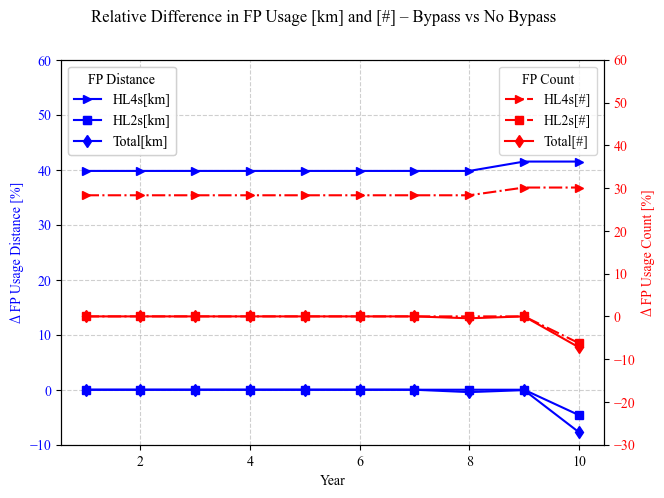

In [11]:
year = np.arange(1, total_simulation_time + 1)

# Plotting
fig, ax1 = plt.subplots(figsize=(7, 5))
fig.suptitle("Relative Difference in FP Usage [km] and [#] – Bypass vs No Bypass")

# Right Y-axis: Linear scale for degrees
ax2 = ax1.twinx()

# Default fallback labels and markers
default_markers = ['d', 'p', 's', 'o', '>', 'h', '*', 'x']

# Cumulative Fiber Pair usage in km
km_total_noBypass = 0
fp_total_noBypass = 0

for hierarchy_level in processing_level_list_noBypass:
    km = analyse_noBypass.link_data[f"HL{hierarchy_level}"]['Total_effective_FP_new_annual']
    fp = np.sum(analyse_noBypass.link_data[f"HL{hierarchy_level}"]['HL_FPNum'], axis = 1)
    km_total_noBypass += km
    fp_total_noBypass += fp

km_total_HL3Bypassed = 0
fp_total_HL3Bypassed = 0

for hierarchy_level in processing_level_list_HL3Bypassed:
    km = analyse_HL3Bypassed.link_data[f"HL{hierarchy_level}"]['Total_effective_FP_new_annual']
    fp = np.sum(analyse_HL3Bypassed.link_data[f"HL{hierarchy_level}"]['HL_FPNum'], axis = 1)
    km_total_HL3Bypassed += km
    fp_total_HL3Bypassed += fp

for hierarchy_level in processing_level_list_HL3Bypassed:
    
    km_noBypass = analyse_noBypass.link_data[f"HL{hierarchy_level}"]['Total_effective_FP_new_annual'] 
    km_HL3Bypassed = analyse_HL3Bypassed.link_data[f"HL{hierarchy_level}"]['Total_effective_FP_new_annual']

    fp_noBypass = np.sum(analyse_noBypass.link_data[f"HL{hierarchy_level}"]['HL_FPNum'], axis = 1)
    fp_HL3Bypassed = np.sum(analyse_HL3Bypassed.link_data[f"HL{hierarchy_level}"]['HL_FPNum'], axis = 1)

    ax1.plot(year, 100 * ((km_HL3Bypassed - km_noBypass) / km_noBypass),
                f"b-{default_markers[hierarchy_level]}", 
                label = f"HL{hierarchy_level}s[km]", linewidth = 1.5)
    
    ax2.plot(year, 100 * ((fp_HL3Bypassed - fp_noBypass) / fp_noBypass), 
            f"r-.{default_markers[hierarchy_level]}", 
            label = f'HL{hierarchy_level}s[#]', linewidth = 1.5)


ax1.plot(year, 100 * ((km_total_HL3Bypassed - km_total_noBypass) / km_total_noBypass), 
                f"b-d", 
                label='Total[km]', linewidth=1.5)
ax1.set_ylabel("Δ FP Usage Distance [%]", color='blue')
ax1.set_xlabel("Year")
ax1.tick_params(axis='y', labelcolor='blue')


ax2.plot(year, 100 * ((fp_total_HL3Bypassed - fp_total_noBypass) / fp_total_noBypass), 
        'r-d', label = 'Total[#]', linewidth = 1.5)
ax2.set_ylabel("Δ FP Usage Count [%]", color = 'red')
ax2.tick_params(axis = 'y', labelcolor = 'red')

ax1.set_ylim(-10, 60) 
ax2.set_ylim(-30, 60) 
ax1.grid(True, linestyle='--', alpha=0.6)
leg1 = ax1.legend(loc='upper left', title='FP Distance')
leg2 = ax2.legend(loc='upper right', title='FP Count')
ax1.add_artist(leg1)


plt.savefig(save_directory / f"{network_noBypass.topology_name}_Relative_Difference_in_FP_Usage_{channel_spacing}G.pdf", format='pdf', dpi=600, bbox_inches='tight')


# plt.tight_layout()      
plt.show()


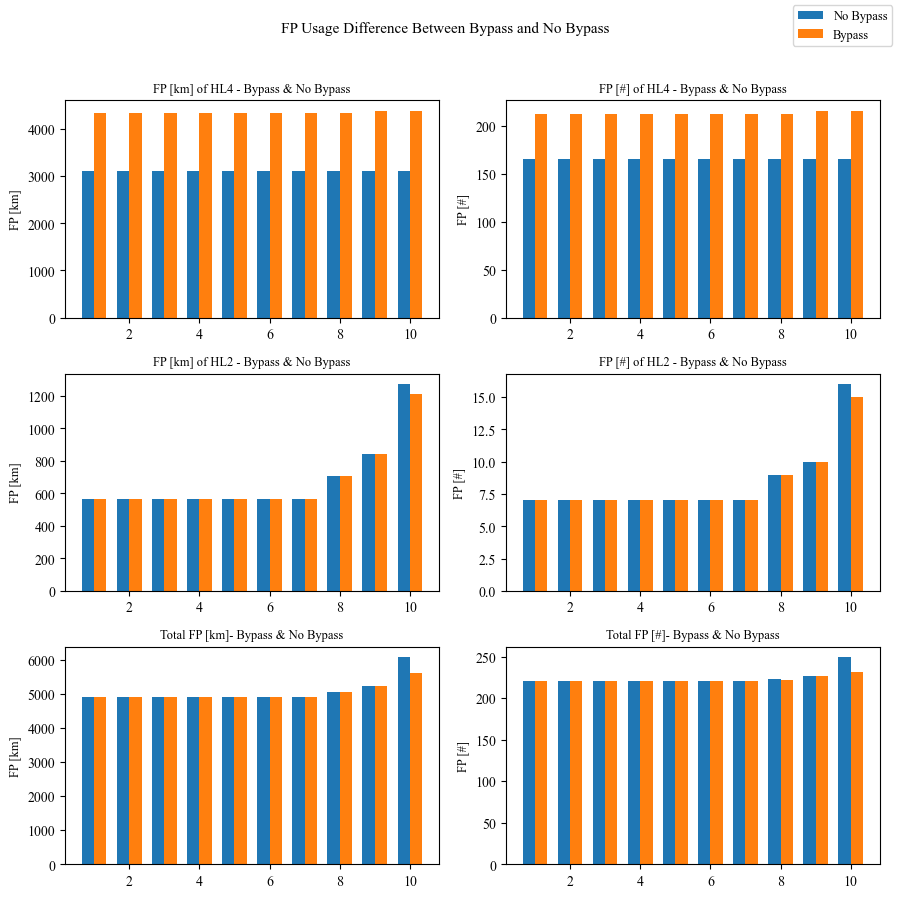

In [12]:
width = 0.35
fig, axs = plt.subplots(3, 2, figsize=(9, 9), sharex = False)
fig.suptitle("FP Usage Difference Between Bypass and No Bypass", fontsize = 11)

for i in range(len(processing_level_list_HL3Bypassed)):

    hierarchy_level = processing_level_list_HL3Bypassed[i]
    km_noBypass = analyse_noBypass.link_data[f"HL{hierarchy_level}"]['Total_effective_FP_new_annual']
    km_HL3Bypassed = analyse_HL3Bypassed.link_data[f"HL{hierarchy_level}"]['Total_effective_FP_new_annual']

    fp_noBypass = np.sum(analyse_noBypass.link_data[f"HL{hierarchy_level}"]['HL_FPNum'], axis = 1)
    fp_HL3Bypassed = np.sum(analyse_HL3Bypassed.link_data[f"HL{hierarchy_level}"]['HL_FPNum'], axis = 1)

    axs[i, 0].bar(year - width/2, km_noBypass, width = width, label = 'No Bypass')
    axs[i, 0].bar(year + width/2, km_HL3Bypassed, width = width, label = 'Bypass')
    axs[i, 0].set_ylabel('FP [km]', fontsize = 9)
    axs[i, 0].set_title(f'FP [km] of HL{hierarchy_level} - Bypass & No Bypass', fontsize = 9)

    axs[i, 1].bar(year - width/2, fp_noBypass, width=width)
    axs[i, 1].bar(year + width/2, fp_HL3Bypassed, width=width)
    axs[i, 1].set_ylabel('FP [#]', fontsize = 9)
    axs[i, 1].set_title(f'FP [#] of HL{hierarchy_level} - Bypass & No Bypass', fontsize = 9)


axs[2, 0].bar(year - width/2, km_total_noBypass, width = width)
axs[2, 0].bar(year + width/2, km_total_HL3Bypassed, width = width)
axs[2, 0].set_ylabel('FP [km]', fontsize = 9)
axs[2, 0].set_title(f'Total FP [km]- Bypass & No Bypass', fontsize = 9)

axs[2, 1].bar(year - width/2, fp_total_noBypass, width=width)
axs[2, 1].bar(year + width/2, fp_total_HL3Bypassed, width=width)
axs[2, 1].set_ylabel('FP [#]', fontsize = 9)
axs[2, 1].set_title(f'Total FP [#]- Bypass & No Bypass', fontsize = 9)

# Unified legend
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', fontsize=9)

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for title

plt.savefig(save_directory / f"{network_noBypass.topology_name}_FP_Usage_Difference_{channel_spacing}G.pdf", format='pdf', dpi=600, bbox_inches='tight')

plt.show()

In [13]:
def safe_percent_diff(a, b):
    with np.errstate(divide='ignore', invalid='ignore'):
        percent = np.where(a != 0, (b - a) / a * 100,
                           np.where(b != 0, np.inf, 0))  # ∞ if b≠0 and a=0, else 0
    return percent

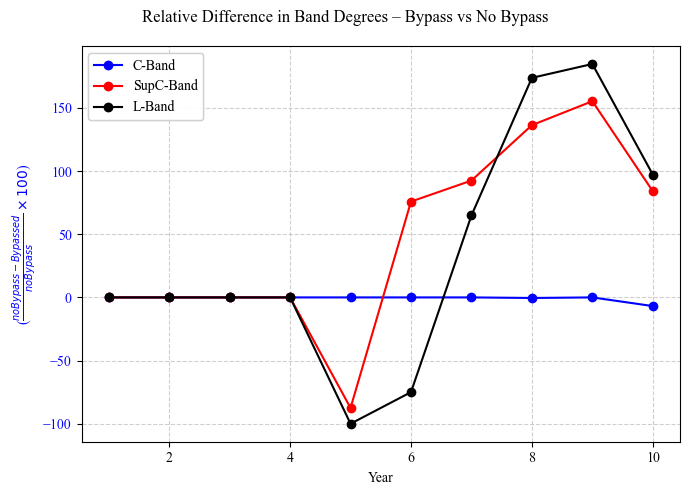

In [14]:
# Plotting
fig, ax1 = plt.subplots(figsize=(7, 5))
fig.suptitle("Relative Difference in Band Degrees – Bypass vs No Bypass")

ax1.plot(year, safe_percent_diff(deg_c_noBypass, deg_c_HL3Bypassed),
                f"b-o", label = 'C-Band', linewidth = 1.5)
ax1.plot(year, safe_percent_diff(deg_superc_noBypass, deg_superc_HL3Bypassed), 
                f"r-o", label='SupC-Band', linewidth = 1.5)
ax1.plot(year, safe_percent_diff(deg_l_noBypass, deg_l_HL3Bypassed), 
                f"k-o", label='L-Band', linewidth = 1.5)

ax1.set_ylabel(r'($\frac{noBypass - Bypassed}{noBypass} \times 100$)', color='blue')
ax1.set_xlabel("Year")
ax1.tick_params(axis='y', labelcolor='blue')

ax1.grid(True, linestyle='--', alpha=0.6)
leg1 = ax1.legend(loc='upper left')
ax1.add_artist(leg1)

plt.tight_layout()   

plt.savefig(save_directory / f"{network_noBypass.topology_name}_Relative_Difference_in_Band_Degrees_{channel_spacing}G.pdf", format='pdf', dpi=600, bbox_inches='tight')


plt.show()

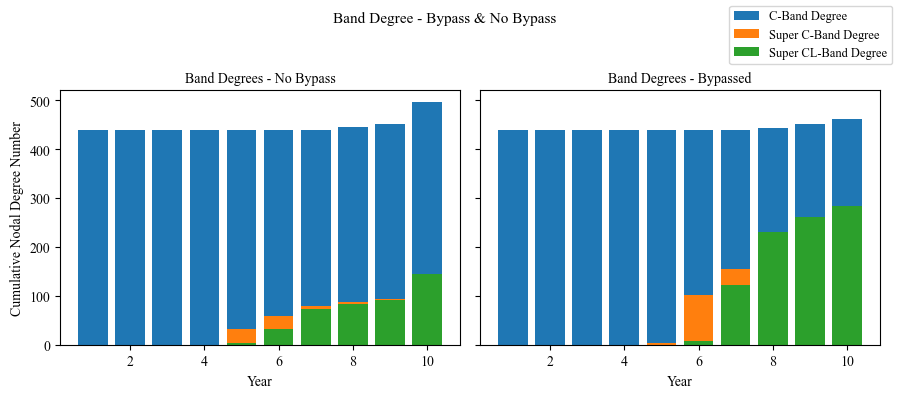

In [15]:
# Values per year
fig, axs = plt.subplots(1, 2, figsize=(9, 4), sharey = True)
fig.suptitle("Band Degree - Bypass & No Bypass", fontsize = 11)

axs[0].bar(year, deg_c_noBypass, label = 'C-Band Degree')
axs[0].bar(year, deg_superc_noBypass, label = 'Super C-Band Degree')
axs[0].bar(year, deg_l_noBypass, label = 'Super CL-Band Degree')
axs[0].set_title('Band Degrees - No Bypass', fontsize = 10)
axs[0].set_xlabel('Year')
axs[0].set_ylabel('Cumulative Nodal Degree Number')

axs[1].bar(year, deg_c_HL3Bypassed, label = 'C-Band Degree')
axs[1].bar(year, deg_superc_HL3Bypassed, label = 'Super C-Band Degree')
axs[1].bar(year, deg_l_HL3Bypassed, label = 'Super CL-Band Degree')
axs[1].set_title('Band Degrees - Bypassed', fontsize = 10)
axs[1].set_xlabel('Year')

# Unified legend
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', fontsize=9)

plt.tight_layout(rect=[0, 0, 1, 0.94])  # Leave space for title

plt.savefig(save_directory / f"{network_noBypass.topology_name}_Band_Degree_BarPlot_{channel_spacing}G.pdf", format='pdf', dpi=600, bbox_inches='tight')

plt.show()

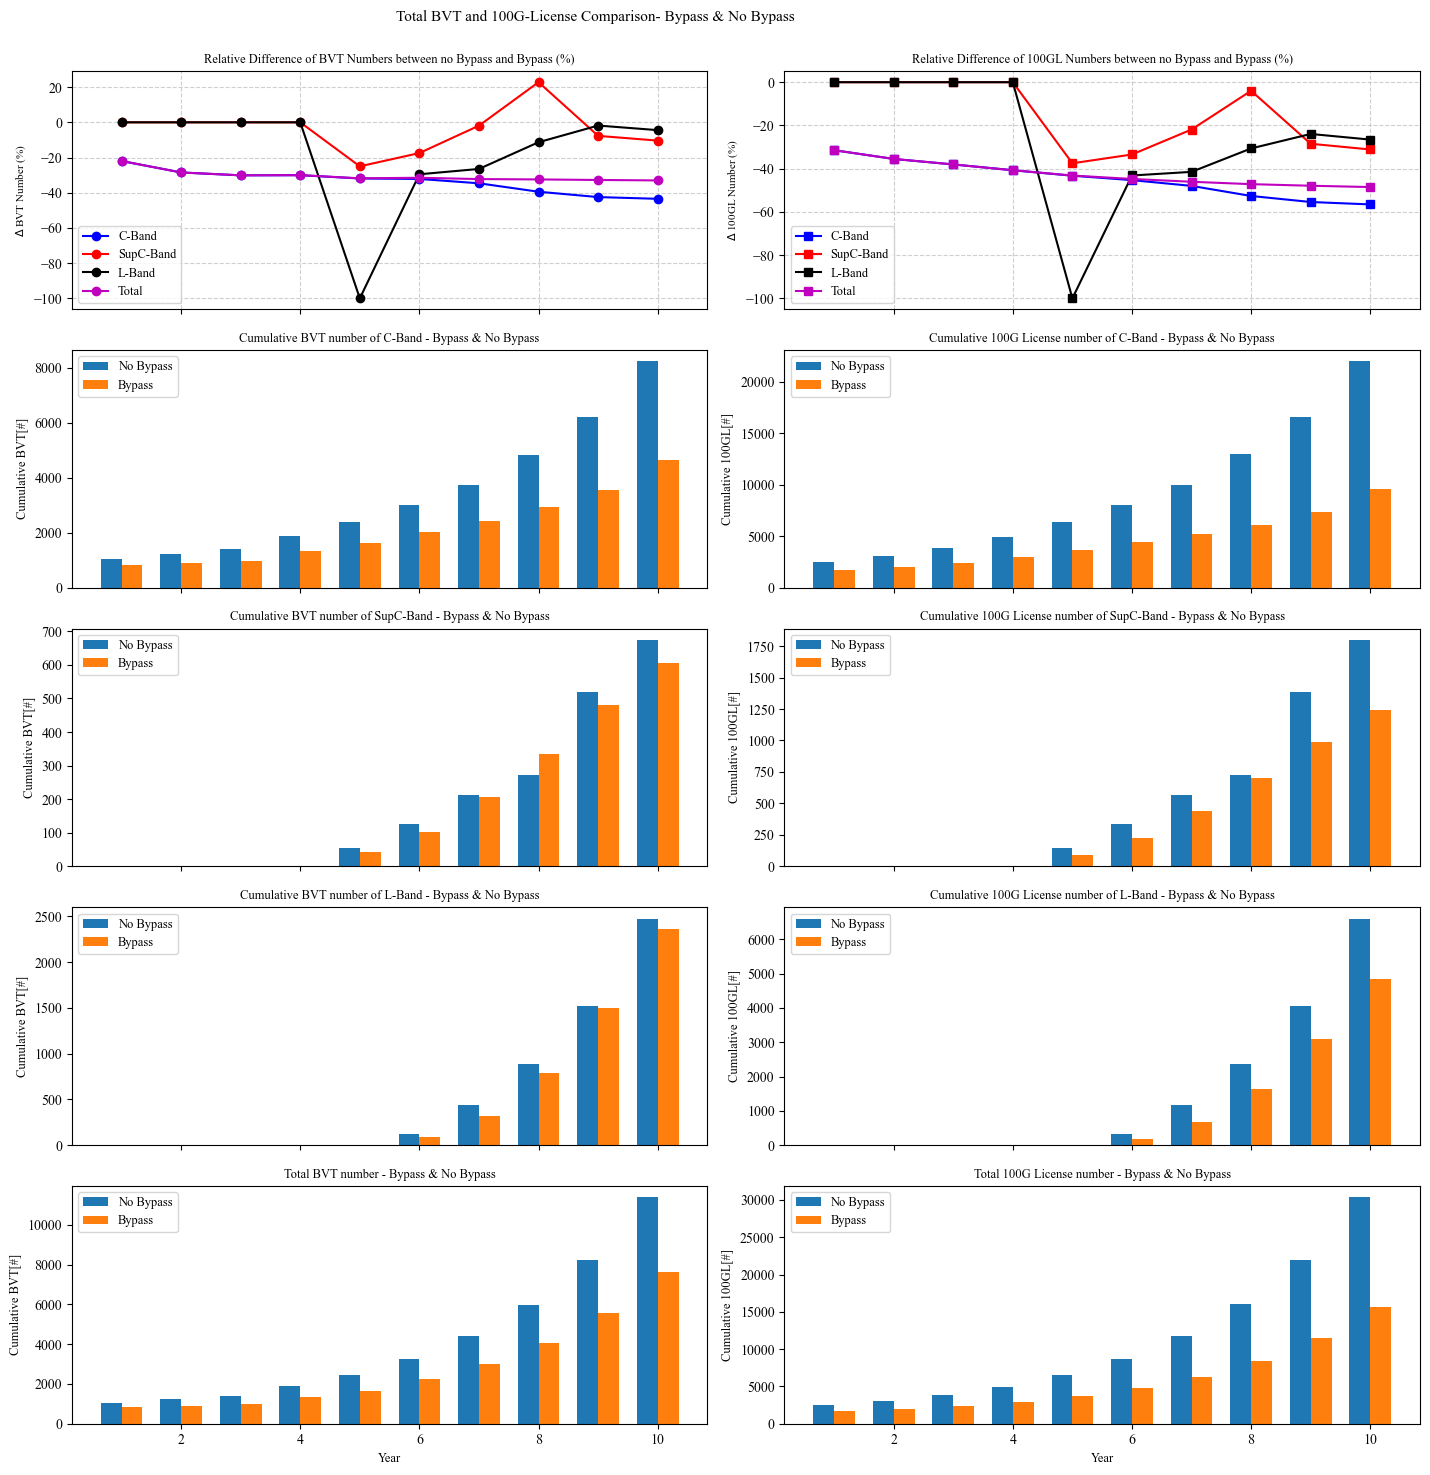

In [16]:
# Cumulative Fiber Pair usage in km
All_BVT_CBand_noBypass = 0
All_BVT_SuperC_noBypass = 0
All_BVT_L_noBypass = 0
Total_License_noBypass = 0

All_BVT_CBand_HL3Bypassed = 0
All_BVT_SuperC_HL3Bypassed = 0
All_BVT_L_HL3Bypassed = 0
Total_License_HL3Bypassed = 0

for hierarchy_level in processing_level_list_noBypass:

    All_BVT_CBand_noBypass += analyse_noBypass.bvt_data[f"HL{hierarchy_level}"]['HL_BVTNum_CBand']
    All_BVT_SuperC_noBypass += analyse_noBypass.bvt_data[f"HL{hierarchy_level}"]['HL_BVTNum_SuperCBand']
    All_BVT_L_noBypass += analyse_noBypass.bvt_data[f"HL{hierarchy_level}"]['HL_BVTNum_LBand']
    Total_License_noBypass += analyse_noBypass.bvt_data[f"HL{hierarchy_level}"]['HL_All_100G_lincense']

for hierarchy_level in processing_level_list_HL3Bypassed:

    All_BVT_CBand_HL3Bypassed += analyse_HL3Bypassed.bvt_data[f"HL{hierarchy_level}"]['HL_BVTNum_CBand']
    All_BVT_SuperC_HL3Bypassed += analyse_HL3Bypassed.bvt_data[f"HL{hierarchy_level}"]['HL_BVTNum_SuperCBand']
    All_BVT_L_HL3Bypassed += analyse_HL3Bypassed.bvt_data[f"HL{hierarchy_level}"]['HL_BVTNum_LBand']
    Total_License_HL3Bypassed += analyse_HL3Bypassed.bvt_data[f"HL{hierarchy_level}"]['HL_All_100G_lincense']


Total_BVT_noBypass = All_BVT_CBand_noBypass + All_BVT_SuperC_noBypass + All_BVT_L_noBypass
Total_BVT_HL3Bypassed = All_BVT_CBand_HL3Bypassed + All_BVT_SuperC_HL3Bypassed + All_BVT_L_HL3Bypassed

CBand_100G_License_noBypass = (All_BVT_CBand_noBypass / Total_BVT_noBypass) * Total_License_noBypass
CBand_100G_License_HL3Bypassed = (All_BVT_CBand_HL3Bypassed / Total_BVT_HL3Bypassed) * Total_License_HL3Bypassed

SupCBand_100G_License_noBypass = (All_BVT_SuperC_noBypass / Total_BVT_noBypass) * Total_License_noBypass
SupCBand_100G_License_HL3Bypassed = (All_BVT_SuperC_HL3Bypassed / Total_BVT_HL3Bypassed) * Total_License_HL3Bypassed

LBand_100G_License_noBypass = (All_BVT_L_noBypass / Total_BVT_noBypass) * Total_License_noBypass
LBand_100G_License_HL3Bypassed = (All_BVT_L_HL3Bypassed / Total_BVT_HL3Bypassed) * Total_License_HL3Bypassed

Total_100G_License_noBypass = CBand_100G_License_noBypass + SupCBand_100G_License_noBypass + LBand_100G_License_noBypass
Total_100G_License_HL3Bypassed = CBand_100G_License_HL3Bypassed + SupCBand_100G_License_HL3Bypassed + LBand_100G_License_HL3Bypassed

# Values per year
fig, axs = plt.subplots(5, 2, figsize=(12, 15), sharex = True)
fig.suptitle("Total BVT and 100G-License Comparison- Bypass & No Bypass", fontsize = 11)

axs[0, 0].plot(year, 
         safe_percent_diff(All_BVT_CBand_noBypass, All_BVT_CBand_HL3Bypassed), 
         f"b-o", label='C-Band', linewidth = 1.5)
axs[0, 0].plot(year, 
         safe_percent_diff(All_BVT_SuperC_noBypass, All_BVT_SuperC_HL3Bypassed), 
         f"r-o", label='SupC-Band', linewidth = 1.5)
axs[0, 0].plot(year, 
         safe_percent_diff(All_BVT_L_noBypass, All_BVT_L_HL3Bypassed), 
         f"k-o", label='L-Band', linewidth = 1.5)
axs[0, 0].plot(year, 
         safe_percent_diff(Total_BVT_noBypass, Total_BVT_HL3Bypassed), 
         f"m-o", label='Total', linewidth = 1.5)
axs[0, 0].set_ylabel(r'$\Delta$ BVT Number (%)', fontsize = 8)
axs[0, 0].set_title(r'Relative Difference of BVT Numbers between no Bypass and Bypass (%)', fontsize = 9)
axs[0, 0].legend(loc='lower left', fontsize = 9) 
axs[0, 0].grid(True, linestyle='--', alpha=0.6)

axs[0, 1].plot(year, 
         safe_percent_diff(CBand_100G_License_noBypass, CBand_100G_License_HL3Bypassed), 
         f"b-s", label='C-Band', linewidth = 1.5)
axs[0, 1].plot(year, 
         safe_percent_diff(SupCBand_100G_License_noBypass, SupCBand_100G_License_HL3Bypassed), 
         f"r-s", label='SupC-Band', linewidth = 1.5)
axs[0, 1].plot(year, 
         safe_percent_diff(LBand_100G_License_noBypass, LBand_100G_License_HL3Bypassed), 
         f"k-s", label='L-Band', linewidth = 1.5)
axs[0, 1].plot(year, 
         safe_percent_diff(Total_100G_License_noBypass, Total_100G_License_HL3Bypassed), 
         f"m-s", label='Total', linewidth = 1.5)
axs[0, 1].set_ylabel(r'$\Delta$ 100GL Number (%)', fontsize = 8)
axs[0, 1].set_title(r'Relative Difference of 100GL Numbers between no Bypass and Bypass (%)', fontsize = 9)
axs[0, 1].legend(loc='lower left', fontsize = 9) 
axs[0, 1].grid(True, linestyle='--', alpha=0.6)

axs[1, 0].bar(year - width/2, All_BVT_CBand_noBypass, width = width, label = 'No Bypass')
axs[1, 0].bar(year + width/2, All_BVT_CBand_HL3Bypassed, width = width, label = 'Bypass')
axs[1, 0].set_ylabel('Cumulative BVT[#]', fontsize = 9)
axs[1, 0].set_title(f'Cumulative BVT number of C-Band - Bypass & No Bypass', fontsize = 9)
axs[1, 0].legend(loc='upper left', fontsize = 9) 

axs[1, 1].bar(year - width/2, CBand_100G_License_noBypass, width = width, label = 'No Bypass')
axs[1, 1].bar(year + width/2, CBand_100G_License_HL3Bypassed, width = width, label = 'Bypass')
axs[1, 1].set_ylabel('Cumulative 100GL[#]', fontsize = 9)
axs[1, 1].set_title(f'Cumulative 100G License number of C-Band - Bypass & No Bypass', fontsize = 9)
axs[1, 1].legend(loc='upper left', fontsize = 9) 

axs[2, 0].bar(year - width/2, All_BVT_SuperC_noBypass, width = width, label = 'No Bypass')
axs[2, 0].bar(year + width/2, All_BVT_SuperC_HL3Bypassed, width = width, label = 'Bypass')
axs[2, 0].set_ylabel('Cumulative BVT[#]', fontsize = 9)
axs[2, 0].set_title(f'Cumulative BVT number of SupC-Band - Bypass & No Bypass', fontsize = 9)
axs[2, 0].legend(loc='upper left', fontsize = 9) 

axs[2, 1].bar(year - width/2, SupCBand_100G_License_noBypass, width = width, label = 'No Bypass')
axs[2, 1].bar(year + width/2, SupCBand_100G_License_HL3Bypassed, width = width, label = 'Bypass')
axs[2, 1].set_ylabel('Cumulative 100GL[#]', fontsize = 9)
axs[2, 1].set_title(f'Cumulative 100G License number of SupC-Band - Bypass & No Bypass', fontsize = 9)
axs[2, 1].legend(loc='upper left', fontsize = 9) 

axs[3, 0].bar(year - width/2, All_BVT_L_noBypass, width = width, label = 'No Bypass')
axs[3, 0].bar(year + width/2, All_BVT_L_HL3Bypassed, width = width, label = 'Bypass')
axs[3, 0].set_ylabel('Cumulative BVT[#]', fontsize = 9)
axs[3, 0].set_title(f'Cumulative BVT number of L-Band - Bypass & No Bypass', fontsize = 9)
axs[3, 0].legend(loc='upper left', fontsize = 9) 

axs[3, 1].bar(year - width/2, LBand_100G_License_noBypass, width = width, label = 'No Bypass')
axs[3, 1].bar(year + width/2, LBand_100G_License_HL3Bypassed, width = width, label = 'Bypass')
axs[3, 1].set_ylabel('Cumulative 100GL[#]', fontsize = 9)
axs[3, 1].set_title(f'Cumulative 100G License number of L-Band - Bypass & No Bypass', fontsize = 9)
axs[3, 1].legend(loc='upper left', fontsize = 9) 

axs[4, 0].bar(year - width/2, Total_BVT_noBypass, width = width, label = 'No Bypass')
axs[4, 0].bar(year + width/2, Total_BVT_HL3Bypassed, width = width, label = 'Bypass')
axs[4, 0].set_ylabel('Cumulative BVT[#]', fontsize = 9)
axs[4, 0].set_title(f'Total BVT number - Bypass & No Bypass', fontsize = 9)
axs[4, 0].legend(loc='upper left', fontsize = 9) 
axs[4, 0].set_xlabel('Year', fontsize = 9)

axs[4, 1].bar(year - width/2, Total_100G_License_noBypass, width = width, label = 'No Bypass')
axs[4, 1].bar(year + width/2, Total_100G_License_HL3Bypassed, width = width, label = 'Bypass')
axs[4, 1].set_ylabel('Cumulative 100GL[#]', fontsize = 9)
axs[4, 1].set_title(f'Total 100G License number - Bypass & No Bypass', fontsize = 9)
axs[4, 1].legend(loc='upper left', fontsize = 9) 
axs[4, 1].set_xlabel('Year', fontsize = 9)

plt.tight_layout(rect=[0, 0, 1.2, 0.98])  # Leave space for title

plt.savefig(save_directory / f"{network_noBypass.topology_name}_BVT_100GL_Comparison_{channel_spacing}G.pdf", format='pdf', dpi=600, bbox_inches='tight')


plt.show()

In [17]:
df_cost_noBypass = analyse_noBypass.calc_cost(save_flag = 0)
df_cost_HL3Bypassed = analyse_HL3Bypassed.calc_cost(save_flag = 0)

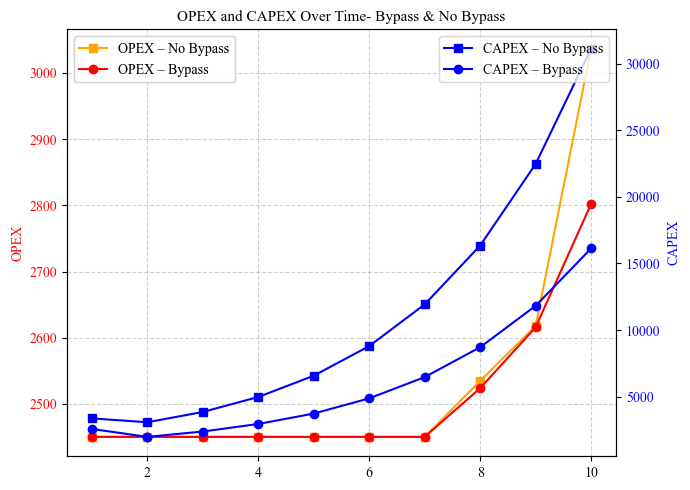

In [18]:
fig, axs1 = plt.subplots(figsize=(7, 5))
# fig.set_title("OPEX and CAPEX Over Time- Bypass & No Bypass", fontsize = 11)
axs2 = axs1.twinx()

axs1.plot(year, df_cost_noBypass['OPEX'], color = 'orange', marker = 's', label='OPEX – No Bypass')
axs1.plot(year, df_cost_HL3Bypassed['OPEX'], f"r-o", label='OPEX – Bypass')
axs1.set_ylabel("OPEX", color = 'red')
axs1.tick_params(axis = 'y', labelcolor = 'red')
axs1.grid(True, linestyle='--', alpha=0.6)

axs2.plot(year, df_cost_noBypass['CAPEX'], f"b-s", label='CAPEX – No Bypass')
axs2.plot(year, df_cost_HL3Bypassed['CAPEX'], f"b-o", label='CAPEX – Bypass')
axs2.set_ylabel("CAPEX", color = 'blue')
axs2.tick_params(axis = 'y', labelcolor = 'blue')

leg1 = axs1.legend(loc='upper left')
leg2 = axs2.legend(loc='upper right')
axs1.add_artist(leg1)

plt.title("OPEX and CAPEX Over Time- Bypass & No Bypass", fontsize = 11)
plt.tight_layout()
plt.savefig(save_directory / f"{network_noBypass.topology_name}_OPEX_CAPEX_Over_Time_{channel_spacing}G.pdf", format='pdf', dpi=600, bbox_inches='tight')
plt.show()


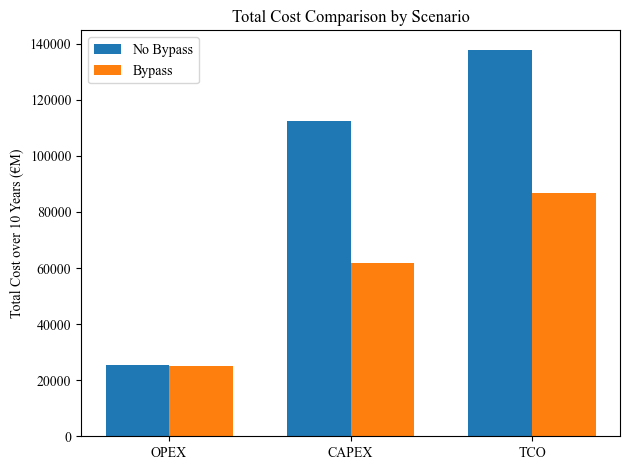

In [19]:
labels = ['OPEX', 'CAPEX', 'TCO']
bypass_totals = [df_cost_HL3Bypassed['OPEX'].sum(), df_cost_HL3Bypassed['CAPEX'].sum(), df_cost_HL3Bypassed['OPEX'].sum() + df_cost_HL3Bypassed['CAPEX'].sum()]
nobypass_totals = [df_cost_noBypass['OPEX'].sum(), df_cost_noBypass['CAPEX'].sum(), df_cost_noBypass['OPEX'].sum() + df_cost_noBypass['CAPEX'].sum()]

x = np.arange(len(labels))
width = 0.35

plt.bar(x - width/2, nobypass_totals, width, label='No Bypass')
plt.bar(x + width/2, bypass_totals, width, label='Bypass')

plt.xticks(x, labels)
plt.ylabel("Total Cost over 10 Years (€M)")
plt.title("Total Cost Comparison by Scenario")
plt.legend()
plt.tight_layout()
plt.savefig(save_directory / f"{network_noBypass.topology_name}_Cost_Comparison_{channel_spacing}G.pdf", format='pdf', dpi=600, bbox_inches='tight')
plt.show()

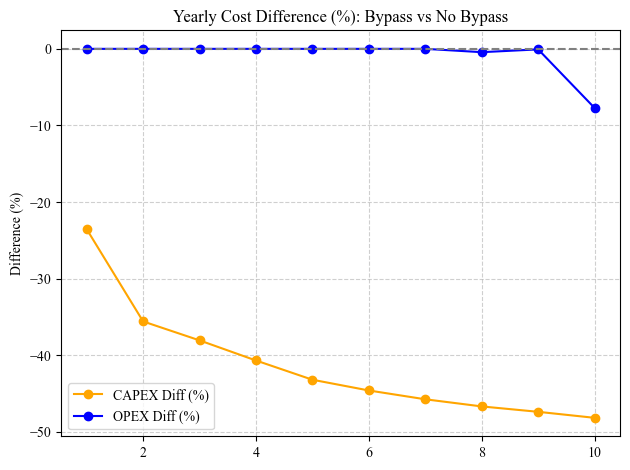

In [20]:
plt.plot(year, safe_percent_diff(df_cost_noBypass['CAPEX'], df_cost_HL3Bypassed['CAPEX']), 
         color='orange', marker='o', linestyle='-', label='CAPEX Diff (%)')

plt.plot(year, safe_percent_diff(df_cost_noBypass['OPEX'], df_cost_HL3Bypassed['OPEX']),
         f"b-o", label='OPEX Diff (%)')
plt.axhline(0, color='gray', linestyle='--')
plt.title("Yearly Cost Difference (%): Bypass vs No Bypass")
plt.ylabel("Difference (%)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.savefig(save_directory / f"{network_noBypass.topology_name}_Yearly_Cost_Diff_{channel_spacing}G.pdf", format='pdf', dpi=600, bbox_inches='tight')

plt.show()


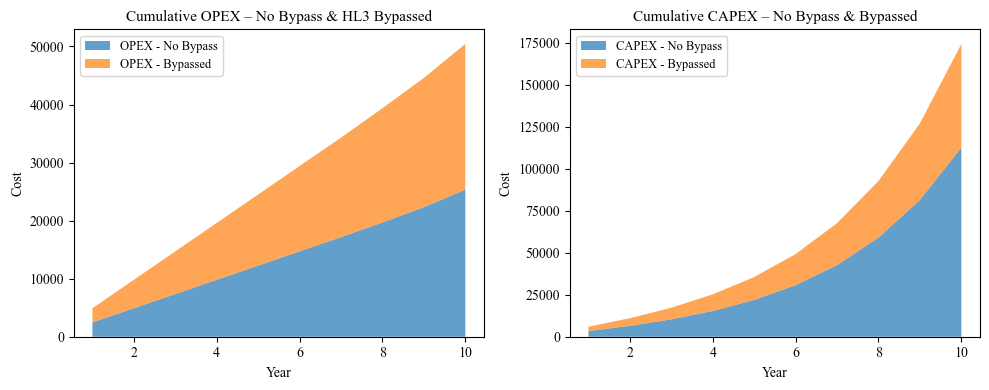

In [21]:
fig, axs = plt.subplots(1, 2, figsize = (10, 4))

axs[0].stackplot(year,
              df_cost_noBypass['OPEX'].cumsum(),
              df_cost_HL3Bypassed['OPEX'].cumsum(),
              labels=['OPEX - No Bypass', 'OPEX - Bypassed'],
              alpha = 0.7)
axs[0].set_title("Cumulative OPEX – No Bypass & HL3 Bypassed", fontsize = 11)
axs[0].set_ylabel("Cost")
axs[0].set_xlabel('Year')
axs[0].legend(fontsize = 9)

axs[1].stackplot(year,
              df_cost_noBypass['CAPEX'].cumsum(),
              df_cost_HL3Bypassed['CAPEX'].cumsum(),
              labels=['CAPEX - No Bypass', 'CAPEX - Bypassed'],
              alpha = 0.7)
axs[1].set_title("Cumulative CAPEX – No Bypass & Bypassed", fontsize = 11)
axs[1].set_ylabel("Cost")
axs[1].set_xlabel('Year')
axs[1].legend(fontsize = 9)


plt.tight_layout()

plt.savefig(save_directory / f"{network_noBypass.topology_name}_Cumulative_Cost_{channel_spacing}G.pdf", format='pdf', dpi=600, bbox_inches='tight')


plt.show()

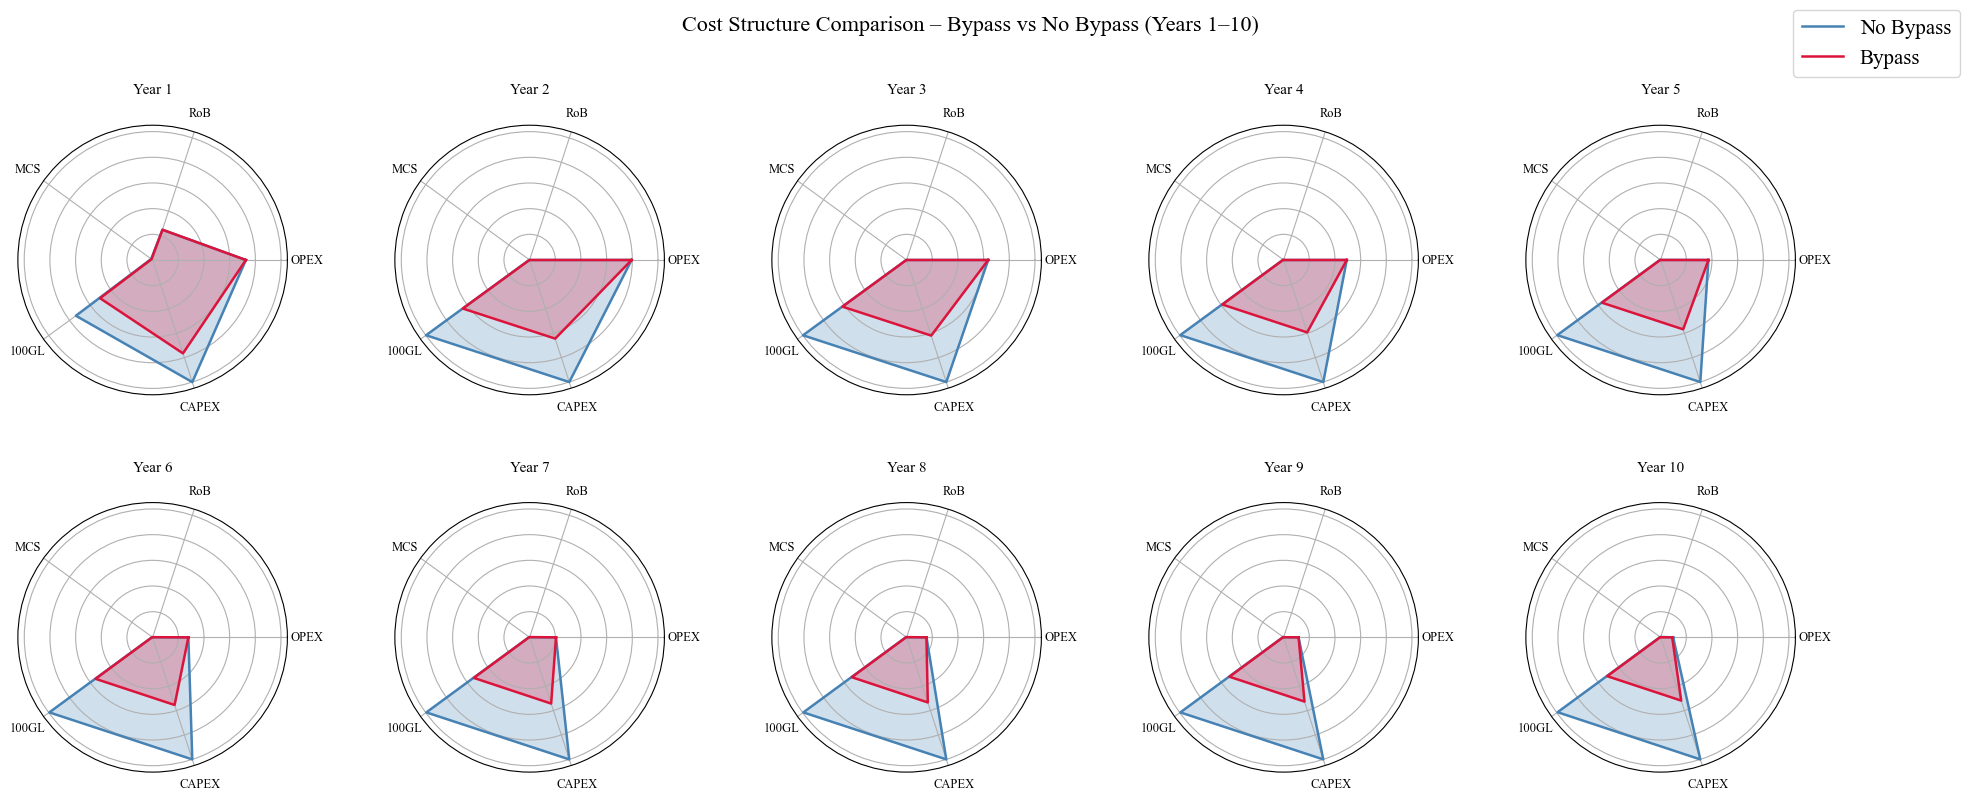

In [22]:
import matplotlib.pyplot as plt
import numpy as np

labels = ['OPEX', 'Capex_RoB', 'Capex_MCS', 'Capex_100GL', 'CAPEX']
n_vars = len(labels)

# Angles for radar
angles = np.linspace(0, 2 * np.pi, n_vars, endpoint=False).tolist()
angles += angles[:1]

# Subplot grid: 2 rows x 5 columns
fig, axs = plt.subplots(2, 5, figsize=(20, 8), subplot_kw={'polar': True})
fig.suptitle("Cost Structure Comparison – Bypass vs No Bypass (Years 1–10)", fontsize=16)

# Plot each year
for i in range(10):
    row = i // 5
    col = i % 5
    ax = axs[row][col]

    # Get values
    val_nb = df_cost_noBypass.loc[i, labels].values.tolist()
    val_bp = df_cost_HL3Bypassed.loc[i, labels].values.tolist()

    # Optional normalization (per year)
    all_vals = val_nb + val_bp
    max_val = max(all_vals)
    val_nb = [v / max_val for v in val_nb]
    val_bp = [v / max_val for v in val_bp]

    # Close the loop
    val_nb += val_nb[:1]
    val_bp += val_bp[:1]

    # Plot
    ax.plot(angles, val_nb, label="No Bypass", color="steelblue", linewidth=1.8)
    ax.fill(angles, val_nb, color="steelblue", alpha=0.25)
    ax.plot(angles, val_bp, label="Bypass", color="crimson", linewidth=1.8)
    ax.fill(angles, val_bp, color="crimson", alpha=0.25)

    # Labels
    ax.set_title(f"Year {i+1}", fontsize=11, pad=10)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(['OPEX', 'RoB', 'MCS', '100GL', 'CAPEX'], fontsize=9)
    ax.set_yticklabels([])
    ax.set_rlabel_position(20)

# Unified legend
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', fontsize=15)

# Layout
plt.tight_layout(rect=[0, 0, 0.95, 0.95])
plt.subplots_adjust(hspace=0.4)  # Increase vertical space between rows

plt.savefig(save_directory / f"{network_noBypass.topology_name}_Cost_Structure_Comparison_{channel_spacing}G.pdf", format='pdf', dpi=600, bbox_inches='tight')
plt.show()


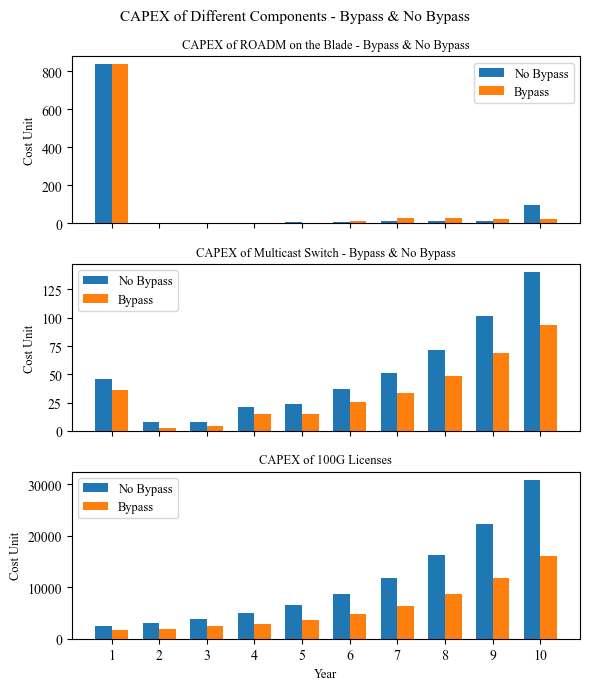

In [23]:
# Values per year
fig, axs = plt.subplots(3, 1, figsize=(6, 7), sharex = True)
fig.suptitle("CAPEX of Different Components - Bypass & No Bypass", fontsize = 11)

axs[0].bar(year - width/2, df_cost_noBypass['Capex_RoB'], width = width, label = 'No Bypass')
axs[0].bar(year + width/2, df_cost_HL3Bypassed['Capex_RoB'], width = width, label = 'Bypass')
axs[0].set_ylabel('Cost Unit', fontsize = 9)
axs[0].set_title('CAPEX of ROADM on the Blade - Bypass & No Bypass', fontsize = 9)
axs[0].legend(loc='upper right', fontsize = 9) 


axs[1].bar(year - width/2, df_cost_noBypass['Capex_MCS'], width = width, label = 'No Bypass')
axs[1].bar(year + width/2, df_cost_HL3Bypassed['Capex_MCS'], width = width, label = 'Bypass')
axs[1].set_ylabel('Cost Unit', fontsize = 9)
axs[1].set_title('CAPEX of Multicast Switch - Bypass & No Bypass', fontsize = 9)
axs[1].legend(loc='upper left', fontsize = 9) 


axs[2].bar(year - width/2, df_cost_noBypass['Capex_100GL'], width = width, label = 'No Bypass')
axs[2].bar(year + width/2, df_cost_HL3Bypassed['Capex_100GL'], width = width, label = 'Bypass')
axs[2].set_ylabel('Cost Unit', fontsize = 9)
axs[2].set_title('CAPEX of 100G Licenses', fontsize = 9)
axs[2].set_xlabel('Year', fontsize = 9)
axs[2].set_xticks(year)
axs[2].legend(loc='upper left', fontsize = 9) 


plt.tight_layout()  # Leave space for title

plt.savefig(save_directory / f"{network_noBypass.topology_name}_CAPEX_Different_Components_{channel_spacing}G.pdf", format='pdf', dpi=600, bbox_inches='tight')


plt.show()

In [24]:
link_state_HL_partisioned_noBypass = np.empty(shape = (total_simulation_time, 0))
for hierarchy_level in processing_level_list_noBypass:
    link_state_HL_partisioned_noBypass = np.hstack((link_state_HL_partisioned_noBypass, analyse_noBypass.link_data[f"HL{hierarchy_level}"]['HL_FPNum']))

In [25]:
link_state_HL_partisioned_HL3Bypassed = np.empty(shape = (total_simulation_time, 0))
for hierarchy_level in processing_level_list_HL3Bypassed:
    link_state_HL_partisioned_HL3Bypassed = np.hstack((link_state_HL_partisioned_HL3Bypassed, analyse_HL3Bypassed.link_data[f"HL{hierarchy_level}"]['HL_FPNum']))

In [26]:
splitter = [166, 47, 7]

In [27]:
weights_HL4 = network_noBypass.weights_array[:166]
weights_HL3 = network_noBypass.weights_array[166 : 166 + 47]
weights_HL2 = network_noBypass.weights_array[166 + 47 : 166 + 47 + 7]

In [28]:
def sort_by_weight(array_not_sorted):

    # Sort indices within each group
    idx_HL4 = np.argsort(weights_HL4)                      # indices 0–165
    idx_HL3 = np.argsort(weights_HL3) + 166                # shift by 166 for global index
    idx_HL2 = np.argsort(weights_HL2) + 166 + 47           # shift by 166 + 47 = 213

    # Concatenate full index order
    sorted_indices = np.concatenate([idx_HL4, idx_HL3, idx_HL2])  # shape (220,)

    # Apply to all years (rows)
    array_sorted = array_not_sorted[:, sorted_indices]  # shape (10, 220), sorted by HL group weights

    return array_sorted

In [29]:
# Apply to all years (rows)
fp_sorted_noBypass = sort_by_weight(link_state_HL_partisioned_noBypass)

# Apply to all years (rows)
fp_sorted_HL3Bypassed = sort_by_weight(link_state_HL_partisioned_HL3Bypassed)

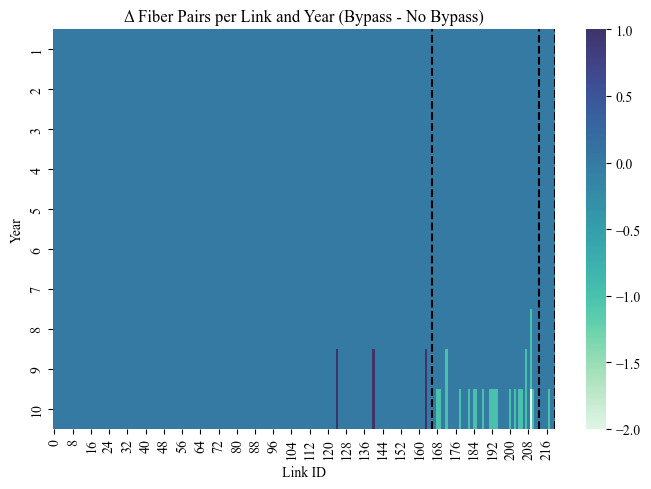

In [30]:
# Example shapes: 30 links × 10 years
delta = fp_sorted_HL3Bypassed  - fp_sorted_noBypass

plt.figure(figsize=(7, 5))
sns.heatmap(delta, cmap='mako_r', center=0)
plt.title('Δ Fiber Pairs per Link and Year (Bypass - No Bypass)')
plt.xlabel('Link ID')
plt.ylabel('Year')
plt.yticks(ticks=np.arange(10) + 0.5, labels=np.arange(1, 11))

splitter_converted = list(accumulate(splitter))
for i in range(len(splitter_converted)):
    plt.axvline(x=splitter_converted[i], color='black', linestyle='--', linewidth=1.5)

plt.tight_layout()
plt.savefig(save_directory / f"{network_noBypass.topology_name}_Delta_Fiber_Pairs_{channel_spacing}G.pdf", format='pdf', dpi=600, bbox_inches='tight')

plt.show()


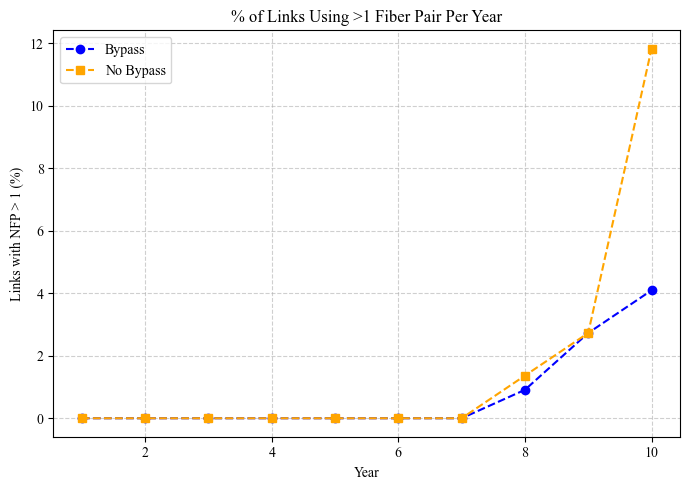

In [31]:
fig, axs = plt.subplots(figsize = (7, 5), sharex = True)

# years_repeated = np.repeat(np.arange(1, 11), 220)

# nfp_flat = pd.DataFrame({
#     'Year': years_repeated,
#     'NFP': link_state_HL_partisioned_HL3Bypassed.flatten(),
#     'Scenario': 'Bypass'
# })

# nfp_flat2 = pd.DataFrame({
#     'Year': years_repeated,
#     'NFP': link_state_HL_partisioned_noBypass.flatten(),
#     'Scenario': 'No Bypass'
# })

# df = pd.concat([nfp_flat, nfp_flat2], ignore_index=True)

# sns.violinplot(x='Year', y='NFP', hue='Scenario', data=df, split=True, inner='point', ax = axs[0])
# axs[0].set_title("Distribution of Fiber Pairs per Link Across Years")

# Step 1: Compute percentage of links with NFP > 1
n_links = 220
nfp_bp = link_state_HL_partisioned_HL3Bypassed
nfp_nb = link_state_HL_partisioned_noBypass

percent_bp = 100 * (nfp_bp > 1).sum(axis=1) / n_links
percent_nb = 100 * (nfp_nb > 1).sum(axis=1) / n_links

axs.plot(year, percent_bp, 'o--', label='Bypass', color='blue')
axs.plot(year, percent_nb, 's--', label='No Bypass', color='orange')
axs.set_title('% of Links Using >1 Fiber Pair Per Year')
axs.set_xlabel('Year')
axs.set_ylabel('Links with NFP > 1 (%)')
axs.grid(True, linestyle='--', alpha=0.6)
axs.legend()

plt.tight_layout()
plt.savefig(save_directory / f"{network_noBypass.topology_name}_More_Than_One_Fiber_Links_{channel_spacing}G.pdf", format='pdf', dpi=600, bbox_inches='tight')

plt.show()


In [32]:
CBand_usage_noBypass = analyse_noBypass.link_data['HL2']['CBand_usage']
superCBand_usage_noBypass = analyse_noBypass.link_data['HL2']['superCBand_usage']
superCLBand_usage_noBypass = analyse_noBypass.link_data['HL2']['superCLBand_usage']

CBand_usage_HL3Bypassed = analyse_HL3Bypassed.link_data['HL2']['CBand_usage']
superCBand_usage_HL3Bypassed = analyse_HL3Bypassed.link_data['HL2']['superCBand_usage']
superCLBand_usage_HL3Bypassed = analyse_HL3Bypassed.link_data['HL2']['superCLBand_usage']

In [33]:
# Apply to all years (rows)
CBand_usage_noBypass_sorted = sort_by_weight(CBand_usage_noBypass)  # shape (10, 220), sorted by HL group weights
superCBand_usage_noBypass_sorted = sort_by_weight(superCBand_usage_noBypass)
superCLBand_usage_noBypass_sorted = sort_by_weight(superCLBand_usage_noBypass)

CBand_usage_HL3Bypassed_sorted = sort_by_weight(CBand_usage_HL3Bypassed)
superCBand_usage_HL3Bypassed_sorted = sort_by_weight(superCBand_usage_HL3Bypassed)
superCLBand_usage_HL3Bypassed_sorted = sort_by_weight(superCLBand_usage_HL3Bypassed)

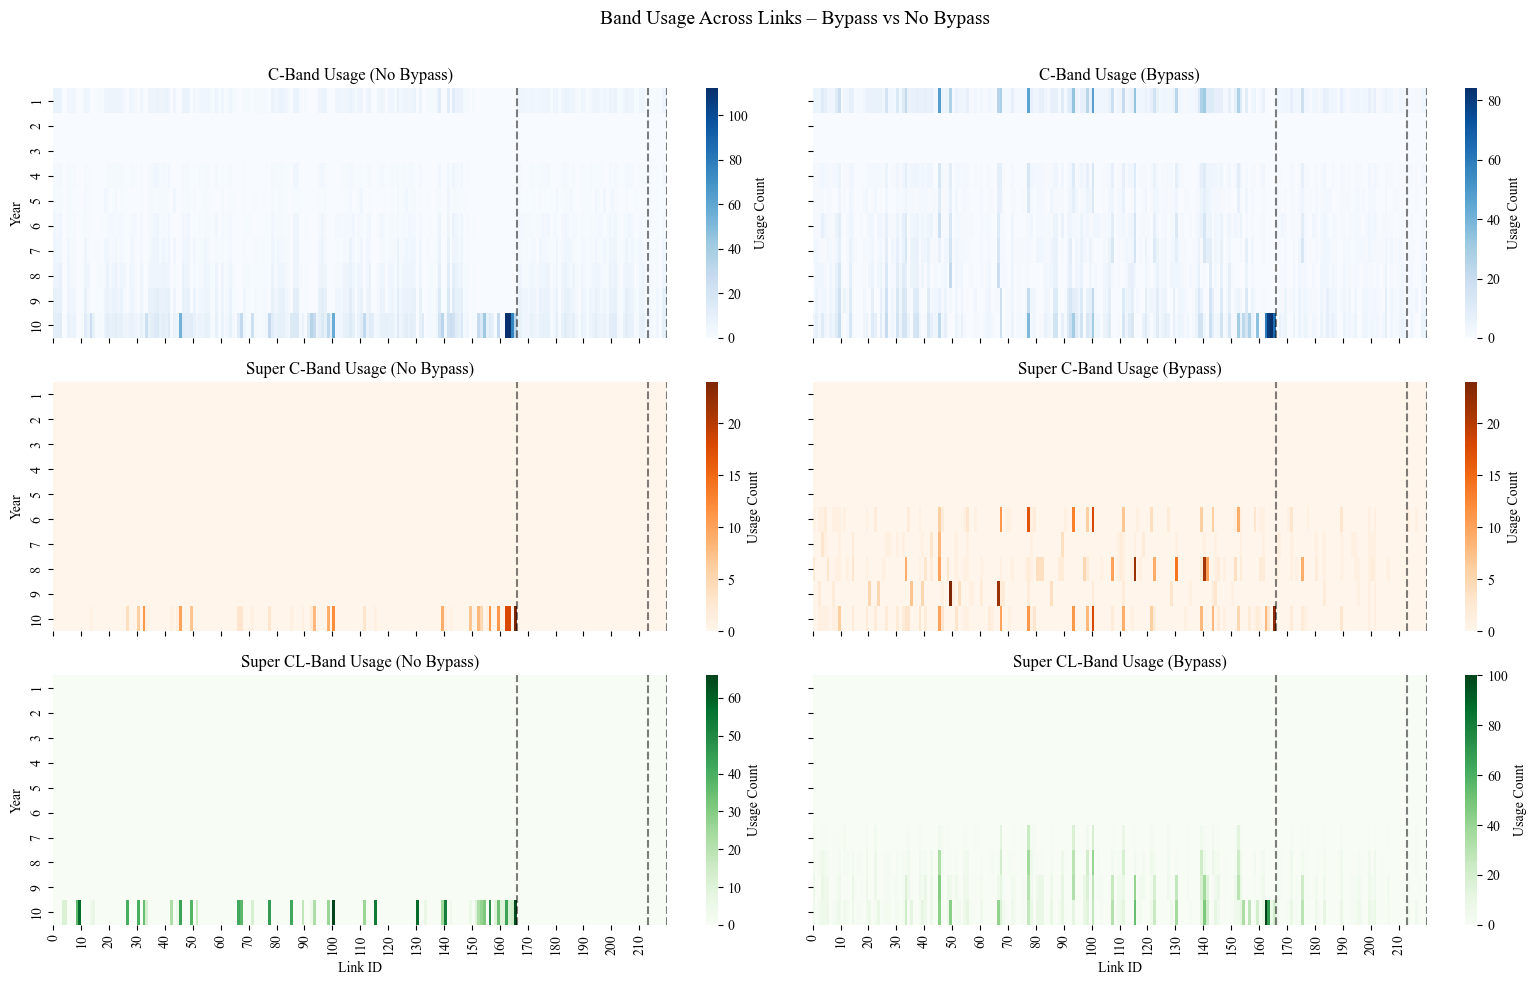

In [34]:
# Example dimensions
num_years, num_links = CBand_usage_noBypass.shape

# Set up figure with 3 rows, 2 columns (No Bypass | Bypass)
fig, axs = plt.subplots(3, 2, figsize=(16, 10), sharex=True, sharey=True)
fig.suptitle("Band Usage Across Links – Bypass vs No Bypass", fontsize = 14)


# Heatmap titles
bands = ['C-Band', 'Super C-Band', 'Super CL-Band']
cmap_list = ['Blues', 'Oranges', 'Greens']
usage_nobypass = [CBand_usage_noBypass_sorted, superCBand_usage_noBypass_sorted, superCLBand_usage_noBypass_sorted]
usage_bypass = [CBand_usage_HL3Bypassed_sorted, superCBand_usage_HL3Bypassed_sorted, superCLBand_usage_HL3Bypassed_sorted]

for i in range(3):
    sns.heatmap(usage_nobypass[i], ax=axs[i][0], cmap=cmap_list[i], cbar_kws={'label': 'Usage Count'})
    axs[i][0].set_title(f"{bands[i]} Usage (No Bypass)")
    axs[i][0].set_ylabel("Year")
    axs[i][0].set_yticks(np.arange(num_years) + 0.5)  # Center tick labels
    axs[i][0].set_yticklabels(np.arange(1, num_years + 1))
    
    sns.heatmap(usage_bypass[i], ax=axs[i][1], cmap=cmap_list[i], cbar_kws={'label': 'Usage Count'})
    axs[i][1].set_title(f"{bands[i]} Usage (Bypass)")
    axs[i][1].set_yticks(np.arange(num_years) + 0.5)
    axs[i][1].set_yticklabels(np.arange(1, num_years + 1))

    splitter_converted = list(accumulate(splitter))
    for m in range(len(splitter_converted)):
        axs[i][0].axvline(x=splitter_converted[m], color='black', linestyle='--', linewidth=1.5, alpha = 0.5)
        axs[i][1].axvline(x=splitter_converted[m], color='black', linestyle='--', linewidth=1.5, alpha = 0.5)


# Label x-axis only on bottom row
axs[2][0].set_xlabel("Link ID")
axs[2][0].set_xticks(np.arange(0, len(network_noBypass.all_links), 10))
axs[2][0].set_xticklabels(np.arange(0, len(network_noBypass.all_links), 10))

axs[2][1].set_xlabel("Link ID")
axs[2][1].set_xticks(np.arange(0, len(network_noBypass.all_links), 10))
axs[2][1].set_xticklabels(np.arange(0, len(network_noBypass.all_links), 10))

plt.tight_layout(rect = [0, 0, 1, 0.97])

plt.savefig(save_directory / f"{network_noBypass.topology_name}_Band_Usage_Across_Links_{channel_spacing}G.pdf", format='pdf', dpi=600, bbox_inches='tight')
plt.show()


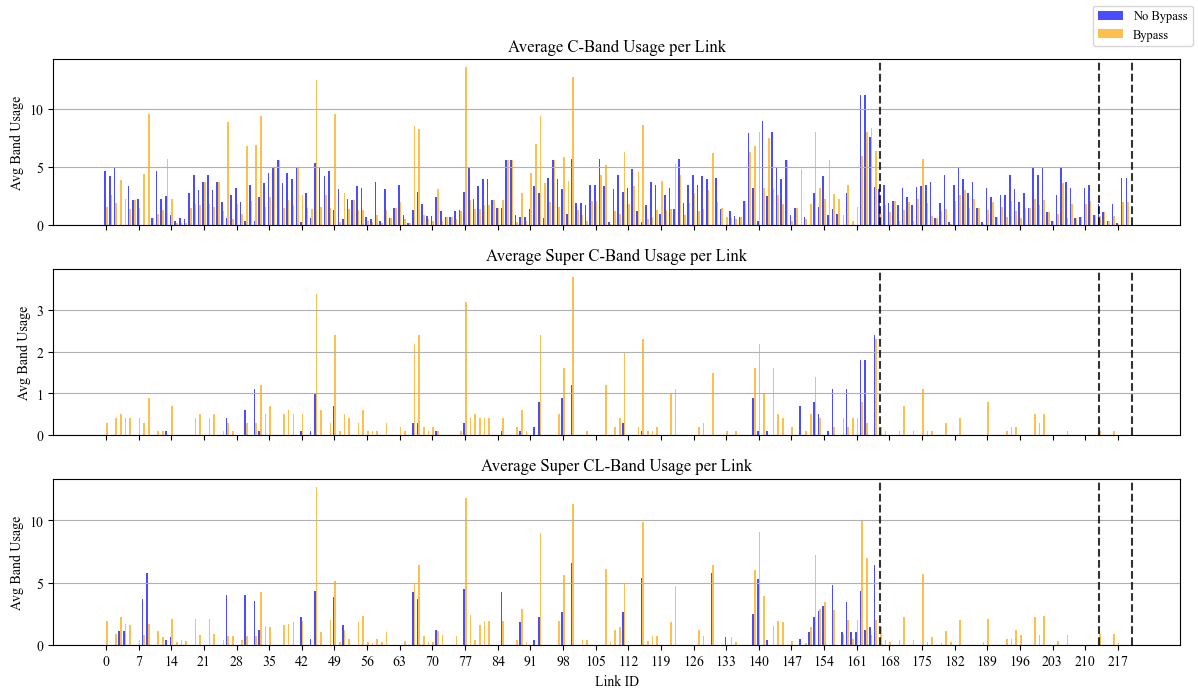

In [35]:
# Compute average traffic per link over all years
avg_CBand_Usage_noBypass = CBand_usage_noBypass_sorted.mean(axis=0)
avg_CBand_Usage_HL3Bypassed = CBand_usage_HL3Bypassed_sorted.mean(axis=0)

avg_superCBand_Usage_noBypass = superCBand_usage_noBypass_sorted.mean(axis=0)
avg_superCBand_Usage_HL3Bypassed = superCBand_usage_HL3Bypassed_sorted.mean(axis=0)

avg_superCLBand_Usage_noBypass = superCLBand_usage_noBypass_sorted.mean(axis=0)
avg_superCLBand_Usage_HL3Bypassed = superCLBand_usage_HL3Bypassed_sorted.mean(axis=0)

# Plotting
link_ids = np.arange(len(network_noBypass.all_links))
bar_width = 0.35

fig, axs = plt.subplots(3, 1, figsize = (12, 7), sharex = True)

axs[0].bar(link_ids - bar_width/2, avg_CBand_Usage_noBypass, width=bar_width, label='No Bypass', color = 'blue', alpha = 0.7)
axs[0].bar(link_ids + bar_width/2, avg_CBand_Usage_HL3Bypassed, width=bar_width, label='Bypass', color = 'orange', alpha = 0.7)
axs[0].set_title('Average C-Band Usage per Link')
axs[0].set_ylabel("Avg Band Usage")
axs[0].grid(True, axis='y')

axs[1].bar(link_ids - bar_width/2, avg_superCBand_Usage_noBypass, width=bar_width, label='No Bypass', color = 'blue', alpha = 0.7)
axs[1].bar(link_ids + bar_width/2, avg_superCBand_Usage_HL3Bypassed, width=bar_width, label='Bypass', color = 'orange', alpha = 0.7)
axs[1].set_title('Average Super C-Band Usage per Link')
axs[1].set_ylabel("Avg Band Usage")
axs[1].grid(True, axis='y')

axs[2].bar(link_ids - bar_width/2, avg_superCLBand_Usage_noBypass, width=bar_width, label='No Bypass', color = 'blue', alpha = 0.7)
axs[2].bar(link_ids + bar_width/2, avg_superCLBand_Usage_HL3Bypassed, width=bar_width, label='Bypass', color = 'orange', alpha = 0.7)
axs[2].set_title('Average Super CL-Band Usage per Link')
axs[2].set_xlabel("Link ID")
axs[2].set_ylabel("Avg Band Usage")
axs[2].grid(True, axis='y')
axs[2].set_xticks(np.arange(0, len(network_noBypass.all_links), 7))

splitter_converted = list(accumulate(splitter))
for m in range(len(splitter_converted)):
    axs[0].axvline(x = splitter_converted[m], color='black', linestyle='--', linewidth=1.5, alpha = 0.8)
    axs[1].axvline(x = splitter_converted[m], color='black', linestyle='--', linewidth=1.5, alpha = 0.8)
    axs[2].axvline(x = splitter_converted[m], color='black', linestyle='--', linewidth=1.5, alpha = 0.8)

# Unified legend
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', fontsize=9)

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig(save_directory / f"{network_noBypass.topology_name}_Avg_Band_Usage_per_Link_{channel_spacing}G.pdf", format='pdf', dpi=600, bbox_inches='tight')

plt.show()


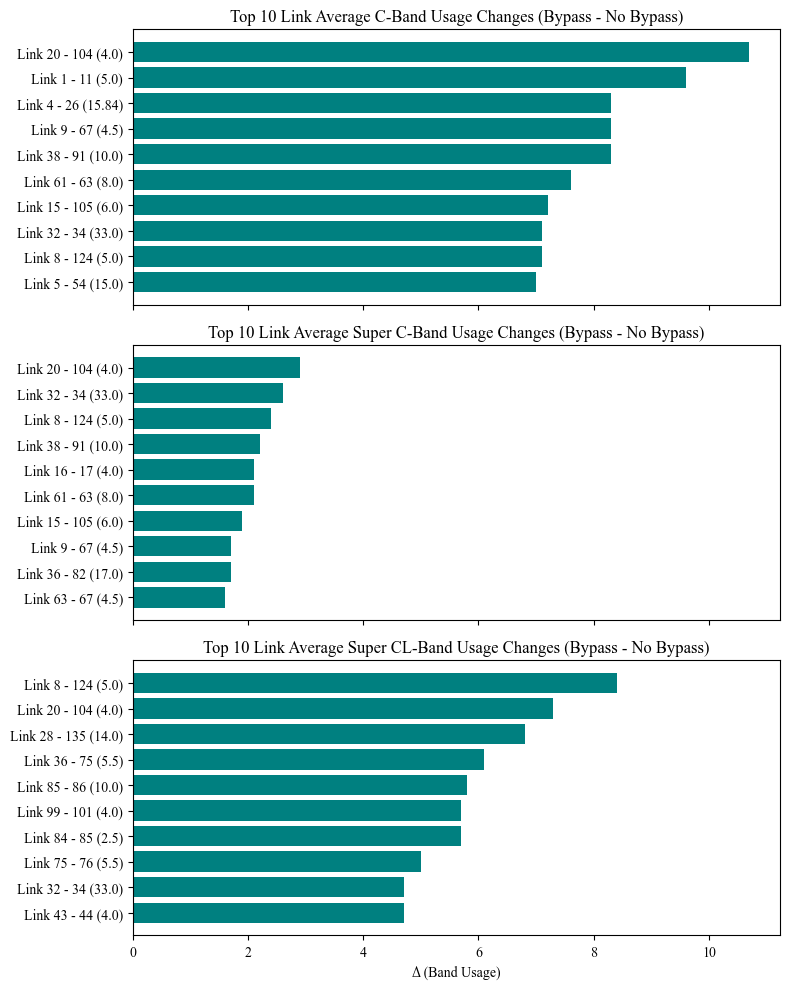

In [36]:
delta_CBand = avg_CBand_Usage_HL3Bypassed - avg_CBand_Usage_noBypass
delta_superCBand = avg_superCBand_Usage_HL3Bypassed - avg_superCBand_Usage_noBypass
delta_superCLBand = avg_superCLBand_Usage_HL3Bypassed -  avg_superCLBand_Usage_noBypass
delta = [delta_CBand, delta_superCBand, delta_superCLBand]
Bands = ['C', 'Super C', 'Super CL']
number_of_top = 10
fig, axs = plt.subplots(3, 1, figsize = (8, 10), sharex = True)

for i in range(3):
    top_change = np.argsort(np.abs(delta[i]))[-number_of_top:]
    top_change_info = network_noBypass.all_links[top_change, :]
    axs[i].barh(range(len(top_change)), delta[i][top_change], color='teal')
    axs[i].set_title(f"Top {number_of_top} Link Average {Bands[i]}-Band Usage Changes (Bypass - No Bypass)")
    axs[i].set_yticks(range(len(top_change)), [f"Link {int(link[0])} - {int(link[1])} ({link[2]})" for link in top_change_info])


axs[2].set_xlabel("Δ (Band Usage)")
plt.tight_layout()
plt.savefig(save_directory / f"{network_noBypass.topology_name}_Top_Links_Band_Usage_{channel_spacing}G.pdf", format='pdf', dpi=600, bbox_inches='tight')

plt.show()


In [37]:
traffic_flow_array_noBypass = analyse_noBypass.link_data['HL2']['traffic_flow_array']
traffic_flow_array_HL3Bypassed = analyse_HL3Bypassed.link_data['HL2']['traffic_flow_array']

In [38]:
traffic_flow_array_noBypass_sorted = sort_by_weight(traffic_flow_array_noBypass)
traffic_flow_array_HL3Bypassed_sorted = sort_by_weight(traffic_flow_array_HL3Bypassed)

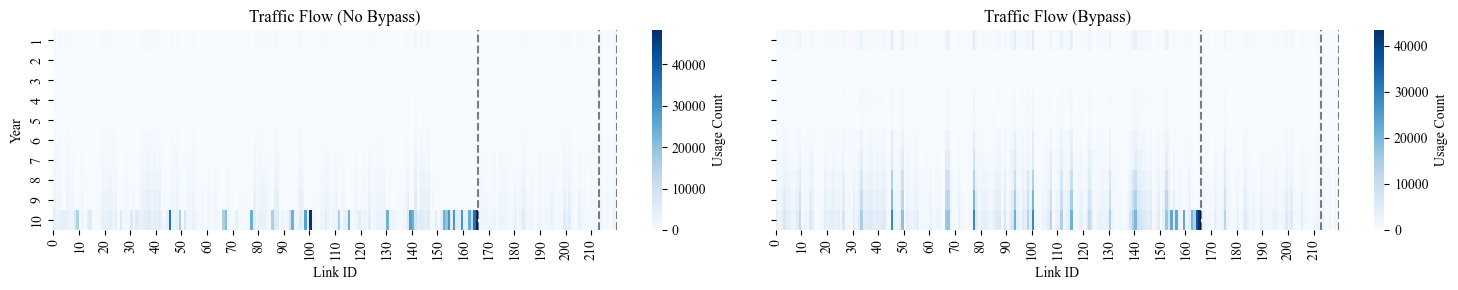

In [39]:
# Example dimensions
num_years, num_links = CBand_usage_noBypass.shape
link_ids = np.arange(num_links)

# Set up figure with 3 rows, 2 columns (No Bypass | Bypass)
fig, axs = plt.subplots(1, 2, figsize=(15, 3), sharey=True)

sns.heatmap(traffic_flow_array_noBypass_sorted, ax=axs[0], cmap='Blues', cbar_kws={'label': 'Usage Count'})
axs[0].set_title(f"Traffic Flow (No Bypass)")
axs[0].set_ylabel("Year")
axs[0].set_yticks(np.arange(num_years) + 0.5)  # Center tick labels
axs[0].set_yticklabels(np.arange(1, num_years + 1))

sns.heatmap(traffic_flow_array_HL3Bypassed_sorted, ax=axs[1], cmap='Blues', cbar_kws={'label': 'Usage Count'})
axs[1].set_title(f"Traffic Flow (Bypass)")
axs[1].set_yticks(np.arange(num_years) + 0.5)  # Center tick labels
axs[1].set_yticklabels(np.arange(1, num_years + 1))

splitter_converted = list(accumulate(splitter))
for m in range(len(splitter_converted)):
    axs[0].axvline(x = splitter_converted[m], color='black', linestyle='--', linewidth=1.5, alpha = 0.5)
    axs[1].axvline(x = splitter_converted[m], color='black', linestyle='--', linewidth=1.5, alpha = 0.5)

# Label x-axis only on bottom row
axs[0].set_xlabel("Link ID")
axs[0].set_xticks(np.arange(0, len(network_noBypass.all_links), 10))
axs[0].set_xticklabels(np.arange(0, len(network_noBypass.all_links), 10))

axs[1].set_xlabel("Link ID")
axs[1].set_xticks(np.arange(0, len(network_noBypass.all_links), 10))
axs[1].set_xticklabels(np.arange(0, len(network_noBypass.all_links), 10))

plt.tight_layout()
plt.savefig(save_directory / f"{network_noBypass.topology_name}_Traffic_Flow_Heatmap_{channel_spacing}G.pdf", format='pdf', dpi=600, bbox_inches='tight')

plt.show()


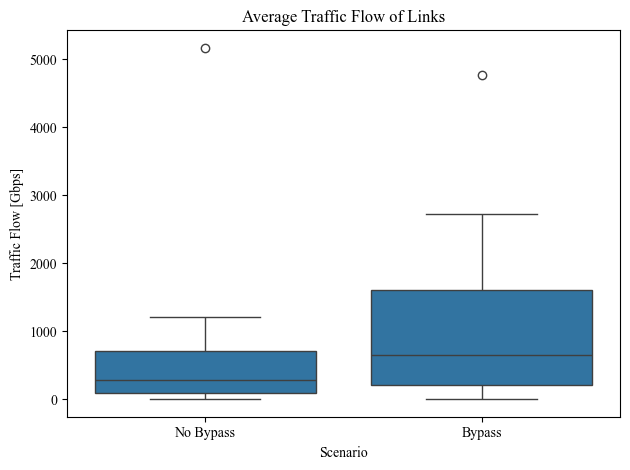

In [40]:
df = pd.DataFrame({
    'Traffic Flow [Gbps]': np.concatenate([traffic_flow_array_noBypass_sorted.mean(axis = 1), traffic_flow_array_HL3Bypassed_sorted.mean(axis = 1)]),
    'Scenario': ['No Bypass'] * len(traffic_flow_array_noBypass_sorted.mean(axis = 1)) + ['Bypass'] * len(traffic_flow_array_HL3Bypassed_sorted.mean(axis = 1))
})

sns.boxplot(x='Scenario', y='Traffic Flow [Gbps]', data=df)
plt.title("Average Traffic Flow of Links")
plt.tight_layout()
plt.savefig(save_directory / f"{network_noBypass.topology_name}_Avg_Traffic_Flow_Links_{channel_spacing}G.pdf", format='pdf', dpi=600, bbox_inches='tight')
plt.show()


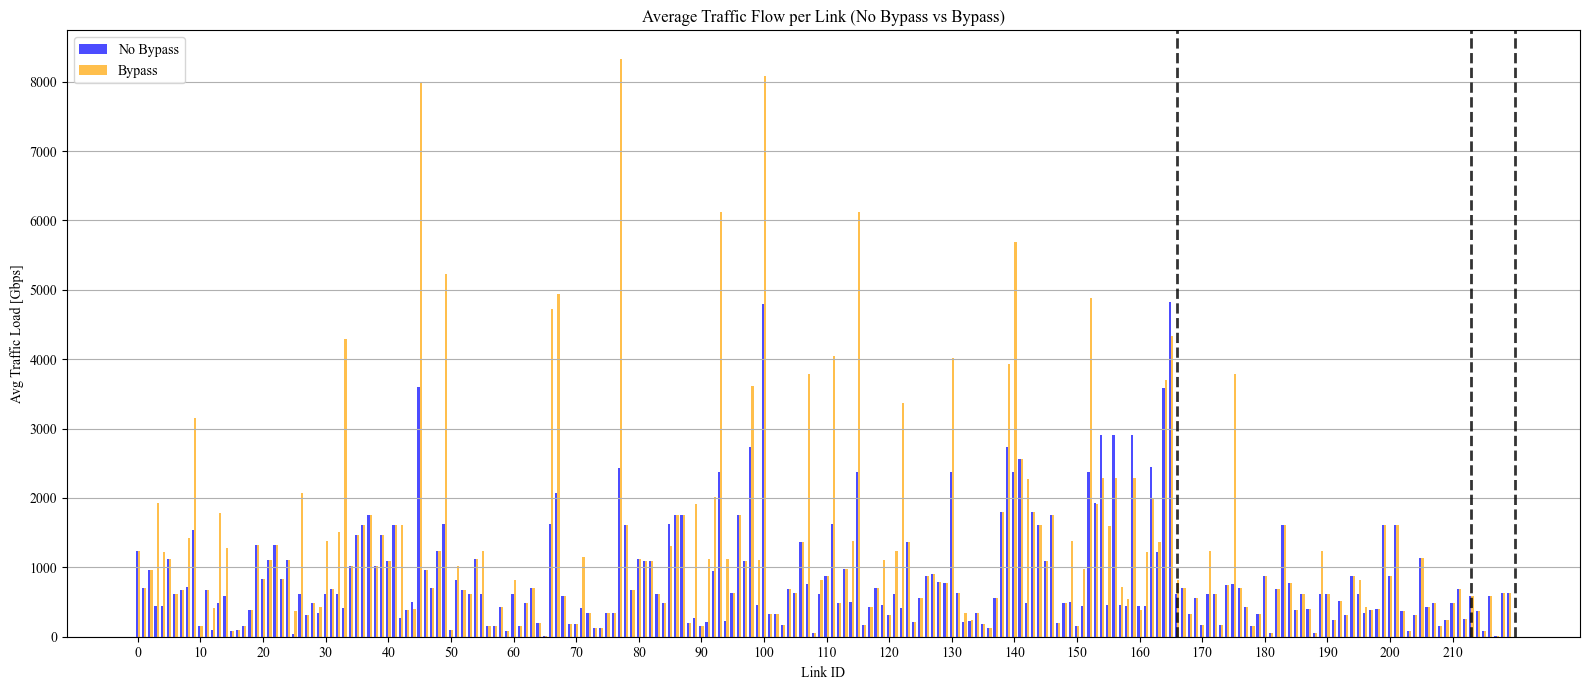

In [41]:
# Compute average traffic per link over all years
avg_traffic_nobypass = traffic_flow_array_noBypass_sorted.mean(axis=0)
avg_traffic_bypass = traffic_flow_array_HL3Bypassed_sorted.mean(axis=0)

# sorted_indices = np.argsort(avg_traffic_nobypass + avg_traffic_bypass)
# avg_traffic_nobypass = avg_traffic_nobypass[sorted_indices]
# avg_traffic_bypass = avg_traffic_bypass[sorted_indices]
# link_ids = np.arange(len(avg_traffic_nobypass))

# Plotting
link_ids = np.arange(len(avg_traffic_nobypass))
bar_width = 0.35

plt.figure(figsize = (16, 7))
plt.bar(link_ids - bar_width/2, avg_traffic_nobypass, width=bar_width, label='No Bypass', color = 'blue', alpha = 0.7)
plt.bar(link_ids + bar_width/2, avg_traffic_bypass, width=bar_width, label='Bypass', color = 'orange', alpha = 0.7)

splitter_converted = list(accumulate(splitter))
for m in range(len(splitter_converted)):
    plt.axvline(x = splitter_converted[m], color='black', linestyle='--', linewidth=2, alpha = 0.8)

plt.xlabel("Link ID")
plt.xticks(np.arange(0, len(network_noBypass.all_links), 10), np.arange(0, len(network_noBypass.all_links), 10))
plt.ylabel("Avg Traffic Load [Gbps]")
plt.title("Average Traffic Flow per Link (No Bypass vs Bypass)")
plt.legend()
plt.grid(True, axis='y')
plt.tight_layout()
plt.savefig(save_directory / f"{network_noBypass.topology_name}_Avg_Traffic_Flow_per_Link_{channel_spacing}G.pdf", format='pdf', dpi=600, bbox_inches='tight')

plt.show()


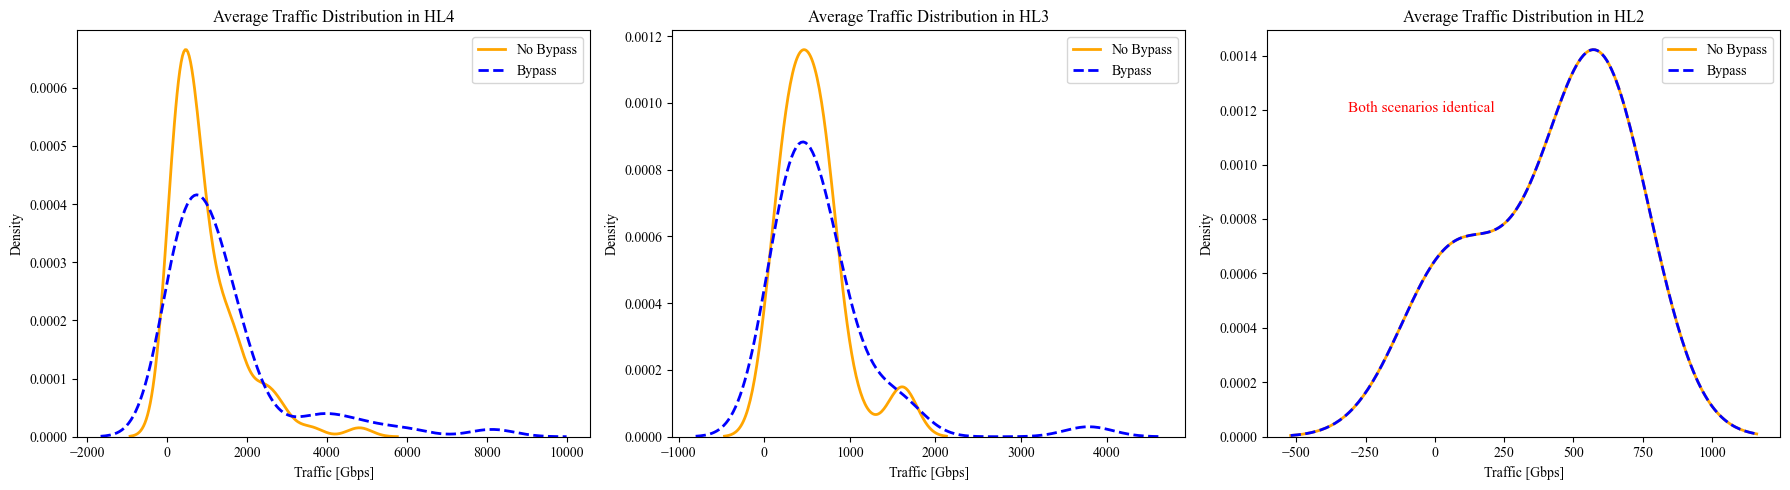

In [42]:
# Average over years
avg_traffic_nb = traffic_flow_array_noBypass_sorted.mean(axis=0)
avg_traffic_bp = traffic_flow_array_HL3Bypassed_sorted.mean(axis=0)

# Split into subdomains
subdomains = {
    "HL4": slice(0, 166),
    "HL3": slice(166, 213),
    "HL2": slice(213, 220)
}

# Plot
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

for i, (name, link_range) in enumerate(subdomains.items()):

    sns.kdeplot(avg_traffic_nb[link_range], color="orange", label="No Bypass", ax=axs[i], linewidth=2)
    sns.kdeplot(avg_traffic_bp[link_range], color="blue", label="Bypass", ax=axs[i], linewidth=2, linestyle='--')   

    if name == "HL2":
        axs[i].text(0.3, 0.8, "Both scenarios identical", transform=axs[i].transAxes,
            fontsize=11, color='red', ha='center')


    axs[i].set_title(f"Average Traffic Distribution in {name}")
    axs[i].set_xlabel("Traffic [Gbps]")
    axs[i].set_ylabel("Density")
    axs[i].legend()

plt.tight_layout()

plt.savefig(save_directory / f"{network_noBypass.topology_name}_Avg_Traffic_Distribution_{channel_spacing}G.pdf", format='pdf', dpi=600, bbox_inches='tight')


plt.show()


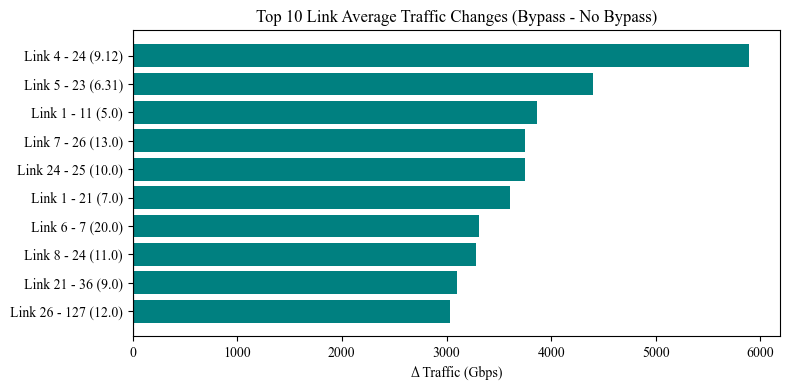

In [43]:
delta = traffic_flow_array_HL3Bypassed.mean(axis = 0) - traffic_flow_array_noBypass.mean(axis = 0)
number_of_top = 10
top_change = np.argsort(np.abs(delta))[-number_of_top:]
top_change_info = network_noBypass.all_links[top_change, :]

plt.figure(figsize=(8, 4))
plt.barh(range(len(top_change)), delta[top_change], color='teal')
plt.yticks(range(len(top_change)), [f"Link {int(link[0])} - {int(link[1])} ({link[2]})" for link in top_change_info])
plt.axvline(0, color='black', linestyle='--')
plt.title(f"Top {number_of_top} Link Average Traffic Changes (Bypass - No Bypass)")
plt.xlabel("Δ Traffic (Gbps)")
plt.tight_layout()

plt.savefig(save_directory / f"{network_noBypass.topology_name}_Top_Links_Traffic_Flow_Change_{channel_spacing}G.pdf", format='pdf', dpi=600, bbox_inches='tight')


plt.show()


In [44]:
primary_paths_noBypass = analyse_noBypass.link_data['HL2']['primary_paths']
primary_paths_HL3Bypassed = analyse_HL3Bypassed.link_data['HL2']['primary_paths']

In [45]:
latency_noBypass = analyse_noBypass.calc_latency(primary_paths = primary_paths_noBypass,
                              processing_level_list = [4, 3, 2], 
                              save_flag = 0)

In [46]:
latency_HL3Bypassed = analyse_HL3Bypassed.calc_latency(primary_paths = primary_paths_HL3Bypassed, 
                              processing_level_list = [4, 2], 
                              save_flag = 0)

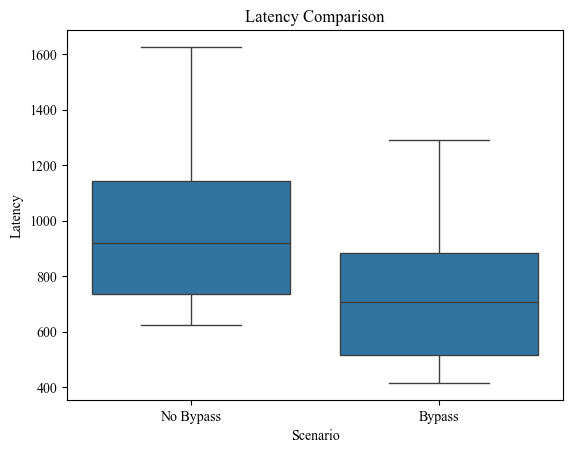

In [47]:
df = pd.DataFrame({
    'Latency': np.concatenate([latency_noBypass, latency_HL3Bypassed]),
    'Scenario': ['No Bypass'] * len(latency_noBypass) + ['Bypass'] * len(latency_HL3Bypassed)
})

sns.boxplot(x='Scenario', y='Latency', data=df)
plt.title("Latency Comparison")
plt.savefig(save_directory / f"{network_noBypass.topology_name}_Latency_Comparison_{channel_spacing}G.pdf", format='pdf', dpi=600, bbox_inches='tight')

plt.show()


In [48]:
def format_stats(data):
    return (
        f"Mean: {np.mean(data):.1f} μs\n"
        f"Std: {np.std(data):.1f} μs\n"
        f"Min: {np.min(data):.1f} μs\n"
        f"Max: {np.max(data):.1f} μs"
    )

nbp_stats = format_stats(latency_noBypass)
bp_stats = format_stats(latency_HL3Bypassed)

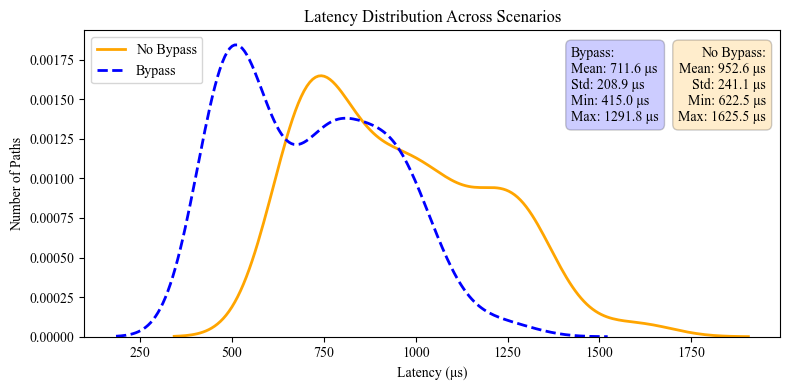

In [49]:
plt.figure(figsize=(8, 4))
sns.kdeplot(latency_noBypass, color="orange", label="No Bypass", linewidth=2)
sns.kdeplot(latency_HL3Bypassed, color="blue", label="Bypass", linewidth=2, linestyle='--')   
plt.xlabel("Latency (μs)")
plt.ylabel("Number of Paths")
plt.legend()
plt.title("Latency Distribution Across Scenarios")

# Add stats as text box
plt.text(0.98, 0.95, f"No Bypass:\n{nbp_stats}", transform=plt.gca().transAxes,
         verticalalignment='top', horizontalalignment='right', fontsize=10,
         bbox=dict(boxstyle="round,pad=0.4", facecolor="orange", alpha=0.2))

plt.text(0.7, 0.95, f"Bypass:\n{bp_stats}", transform=plt.gca().transAxes,
         verticalalignment='top', horizontalalignment='left', fontsize=10,
         bbox=dict(boxstyle="round,pad=0.4", facecolor="blue", alpha=0.2))


plt.tight_layout()
plt.savefig(save_directory / f"{network_noBypass.topology_name}_Latency_Distribution_{channel_spacing}G.pdf", format='pdf', dpi=600, bbox_inches='tight')
plt.show()
